# Linear Regression with PyMC - 2025-05-06
This notebook demonstrates how to perform simple linear regression using a fully Bayesian approach with **PyMC**.

In [75]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

import arviz as az
np.random.seed(1234)

## Simulate data

In [76]:
x = torch.arange(1, 21)
a = 0.2
b = 0.3
sigma = 0.5
epsilon = torch.normal(0.0, sigma, size=(20,))
y = a + b * x + epsilon
data = pd.DataFrame({'x': x, 'y': y})
data.head()

,x,y
0,1,0.816486
1,2,1.192137
2,3,1.271165
3,4,1.992519
4,5,2.447628


Text(0, 0.5, 'y')

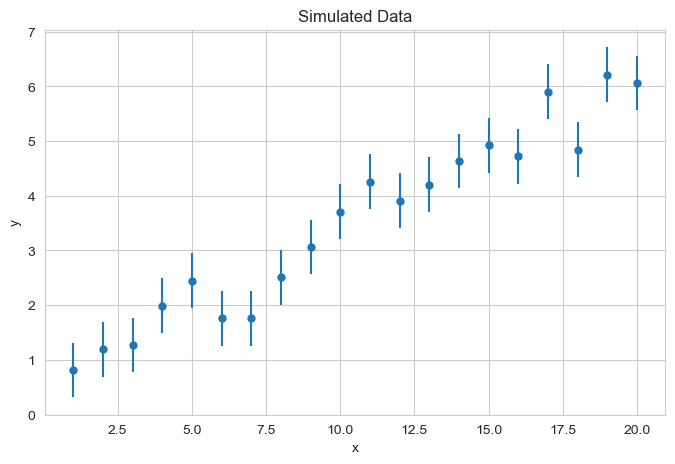

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.errorbar(x, y, yerr=sigma, fmt="o", markersize=5)
ax.set_title('Simulated Data')
ax.set_xlabel('x')
ax.set_ylabel('y')


## Bayesian Linear Regression using Pyro

In [78]:
def model(x, y=None):
    alpha = pyro.sample("alpha", dist.Normal(loc=0, scale=10))
    beta = pyro.sample("beta", dist.Normal(loc=0, scale=10))
    sigma = pyro.sample("sigma", dist.HalfNormal(scale=1))

    mu = alpha + beta * x
    with pyro.plate("data", x):
        pyro.sample("y", dist.Normal(loc=mu, scale=sigma), obs=y)

In [1]:
pyro.render_model(
    model,
    model_args=(x,y),
    render_distributions=True,
    render_params=True
)

NameError: name 'pyro' is not defined

In [80]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000, num_chains=1)
# Note: num_chains > 1 does not work in Jupyter notebooks! It's a Jupyter issue related to multi-processing! 
# For more chains, copy code into a python file and run as a python script.
mcmc.run(x, y=y)
posterior = mcmc.get_samples()

idata = az.from_dict(posterior={k: v.numpy() for k, v in posterior.items()})



Sample: 100%|███████████████████████████████████████| 2000/2000 [00:08, 225.19it/s, step size=3.16e-01, acc. prob=0.931]                


We can make trace plots for our chain:

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

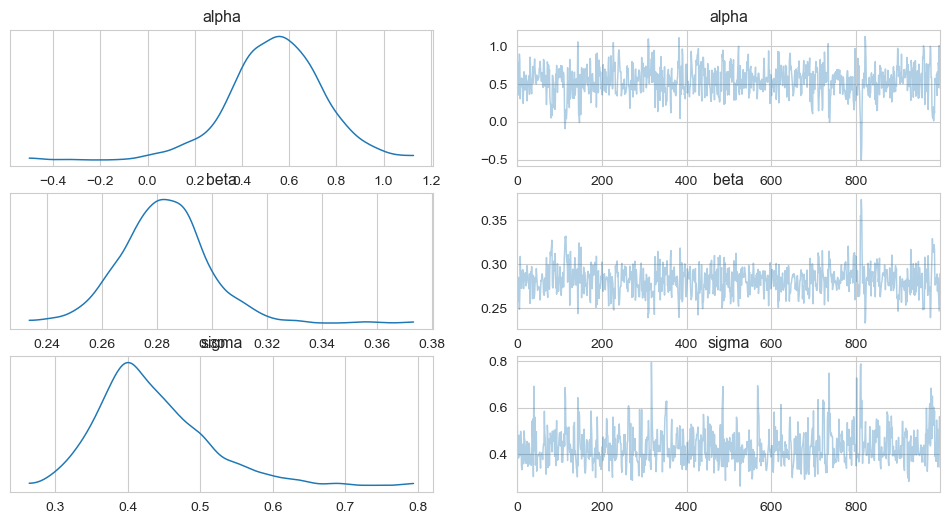

In [81]:
az.plot_trace(mcmc)

In [60]:
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.193,0.179,-0.151,0.497,0.009,0.011,473.0,411.0,NaN
beta,0.296,0.015,0.269,0.324,0.001,0.001,437.0,410.0,NaN
sigma,0.400,0.070,0.282,0.521,0.003,0.003,459.0,537.0,NaN


# posterior

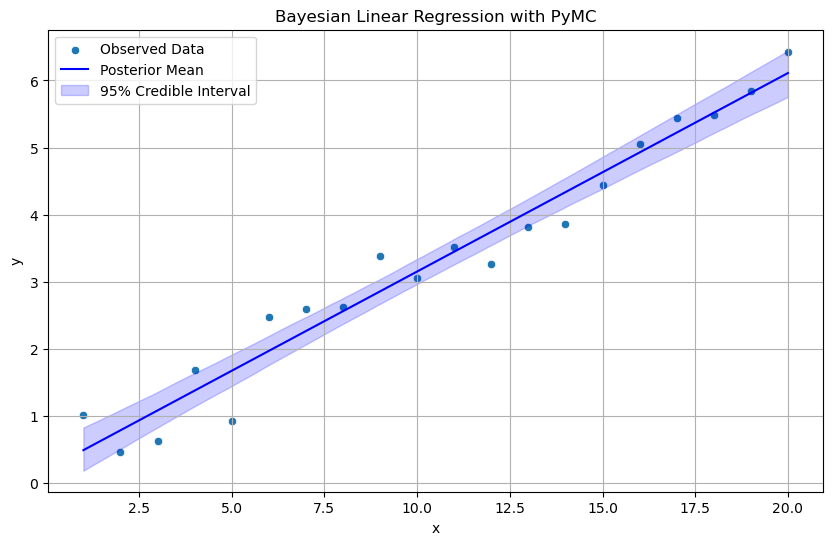

In [61]:
x_vals = torch.linspace(data['x'].min(), data['x'].max(), 100)

# Get stacked posterior samples (1D arrays)
alpha_samples = posterior['alpha']
beta_samples = posterior['beta']

# Broadcast across x_vals (outer product-style)
y_preds = torch.add(alpha_samples.reshape(len(alpha_samples), 1), torch.outer(beta_samples, x_vals))

# Compute summary statistics
y_mean = y_preds.mean(axis=0)
y_lower = torch.quantile(y_preds, 0.025, axis=0)
y_upper = torch.quantile(y_preds, 0.975, axis=0)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='x', y='y', label='Observed Data')
plt.plot(x_vals, y_mean, color='blue', label='Posterior Mean')
plt.fill_between(x_vals, y_lower, y_upper, color='blue', alpha=0.2, label='95% Credible Interval')
plt.title('Bayesian Linear Regression with PyMC')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()


In [14]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.24,0.29,-0.29,0.80,0.01,0.01,1534.18,1782.74,1.0
beta,0.30,0.02,0.25,0.34,0.00,0.00,1524.44,1649.34,1.0
sigma,0.60,0.11,0.42,0.80,0.00,0.00,1668.35,1628.11,1.0


To get posterior predictive samples, we need to uncondition the model on the data:

In [67]:
unconditioned_model = pyro.poutine.uncondition(model)

In [71]:
posterior_predictive = pyro.infer.Predictive(unconditioned_model, posterior, num_samples=1000)(x, y)

In [72]:
posterior_predictive

{'obs': tensor([[0.5892, 0.7536, 0.7695,  ..., 5.5005, 5.6266, 6.6510],
         [0.2412, 0.8190, 0.8571,  ..., 5.2296, 5.6288, 6.2593],
         [0.6081, 0.4548, 1.1523,  ..., 5.5864, 5.5969, 6.4022],
         ...,
         [0.4330, 0.2721, 1.1513,  ..., 5.5394, 4.5438, 6.4435],
         [0.4916, 1.2053, 0.9816,  ..., 5.7358, 6.3359, 6.8112],
         [0.3808, 0.9712, 1.8581,  ..., 5.3598, 6.3580, 5.8418]])}

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(